In [277]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
# setting display format so that large values are shown properly
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [278]:
if os.path.isfile('loan.csv'):
    print("loading from csv")
    loans = pd.read_csv('loan.csv', low_memory=False)
else:
    print("loading from zip")
    loans = pd.read_csv('loan.zip', compression='zip', low_memory=False)

loans.info()

loading from zip
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


In [279]:
print(loans.columns)

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit'],
      dtype='object', length=111)


Getting basic info about the data

In [280]:
loans.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 111 columns):
id                                int64
member_id                         int64
loan_amnt                         int64
funded_amnt                       int64
funded_amnt_inv                   float64
term                              object
int_rate                          object
installment                       float64
grade                             object
sub_grade                         object
emp_title                         object
emp_length                        object
home_ownership                    object
annual_inc                        float64
verification_status               object
issue_d                           object
loan_status                       object
pymnt_plan                        object
url                               object
desc                              object
purpose                           object
title                         

Showing the counts of entries per column

In [281]:
loans.count()

id                            39717
member_id                     39717
loan_amnt                     39717
funded_amnt                   39717
funded_amnt_inv               39717
                              ...  
tax_liens                     39678
tot_hi_cred_lim                   0
total_bal_ex_mort                 0
total_bc_limit                    0
total_il_high_credit_limit        0
Length: 111, dtype: int64

In [282]:
num_rows = loans.shape[0]
num_missing = num_rows - loans.count()
print(num_missing)

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
                              ...  
tax_liens                        39
tot_hi_cred_lim               39717
total_bal_ex_mort             39717
total_bc_limit                39717
total_il_high_credit_limit    39717
Length: 111, dtype: int64


In [283]:
loans.isnull().sum()

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
                              ...  
tax_liens                        39
tot_hi_cred_lim               39717
total_bal_ex_mort             39717
total_bc_limit                39717
total_il_high_credit_limit    39717
Length: 111, dtype: int64

### Finding columns which have NAN

In [284]:
def get_columns_with_nan_percentage(df):
    nan_cols = [{
            "column":c,
            "percentage":round(100*(df[c].isnull().sum()/len(df[c].index)), 2)
            } for c in df.columns if round(100*(df[c].isnull().sum()/len(df[c].index)), 2)>0]
    return nan_cols

In [285]:
print(get_columns_with_nan_percentage(loans))

[{'column': 'emp_title', 'percentage': 6.19}, {'column': 'emp_length', 'percentage': 2.71}, {'column': 'desc', 'percentage': 32.58}, {'column': 'title', 'percentage': 0.03}, {'column': 'mths_since_last_delinq', 'percentage': 64.66}, {'column': 'mths_since_last_record', 'percentage': 92.99}, {'column': 'revol_util', 'percentage': 0.13}, {'column': 'last_pymnt_d', 'percentage': 0.18}, {'column': 'next_pymnt_d', 'percentage': 97.13}, {'column': 'last_credit_pull_d', 'percentage': 0.01}, {'column': 'collections_12_mths_ex_med', 'percentage': 0.14}, {'column': 'mths_since_last_major_derog', 'percentage': 100.0}, {'column': 'annual_inc_joint', 'percentage': 100.0}, {'column': 'dti_joint', 'percentage': 100.0}, {'column': 'verification_status_joint', 'percentage': 100.0}, {'column': 'tot_coll_amt', 'percentage': 100.0}, {'column': 'tot_cur_bal', 'percentage': 100.0}, {'column': 'open_acc_6m', 'percentage': 100.0}, {'column': 'open_il_6m', 'percentage': 100.0}, {'column': 'open_il_12m', 'perce

#### Deleting columns which have 100% NAN

In [286]:
loans = loans.dropna(how='all', axis=1)
print(get_columns_with_nan_percentage(loans))

[{'column': 'emp_title', 'percentage': 6.19}, {'column': 'emp_length', 'percentage': 2.71}, {'column': 'desc', 'percentage': 32.58}, {'column': 'title', 'percentage': 0.03}, {'column': 'mths_since_last_delinq', 'percentage': 64.66}, {'column': 'mths_since_last_record', 'percentage': 92.99}, {'column': 'revol_util', 'percentage': 0.13}, {'column': 'last_pymnt_d', 'percentage': 0.18}, {'column': 'next_pymnt_d', 'percentage': 97.13}, {'column': 'last_credit_pull_d', 'percentage': 0.01}, {'column': 'collections_12_mths_ex_med', 'percentage': 0.14}, {'column': 'chargeoff_within_12_mths', 'percentage': 0.14}, {'column': 'pub_rec_bankruptcies', 'percentage': 1.75}, {'column': 'tax_liens', 'percentage': 0.1}]


#### Deleting columns with more than 90% empty values

In [287]:
loans = loans.drop(['next_pymnt_d', 'mths_since_last_record'], axis=1)
print(get_columns_with_nan_percentage(loans))

[{'column': 'emp_title', 'percentage': 6.19}, {'column': 'emp_length', 'percentage': 2.71}, {'column': 'desc', 'percentage': 32.58}, {'column': 'title', 'percentage': 0.03}, {'column': 'mths_since_last_delinq', 'percentage': 64.66}, {'column': 'revol_util', 'percentage': 0.13}, {'column': 'last_pymnt_d', 'percentage': 0.18}, {'column': 'last_credit_pull_d', 'percentage': 0.01}, {'column': 'collections_12_mths_ex_med', 'percentage': 0.14}, {'column': 'chargeoff_within_12_mths', 'percentage': 0.14}, {'column': 'pub_rec_bankruptcies', 'percentage': 1.75}, {'column': 'tax_liens', 'percentage': 0.1}]


#### Deleting not useful columns like `desc`

In [288]:
loans = loans.drop(['desc'], axis=1)
print(get_columns_with_nan_percentage(loans))

[{'column': 'emp_title', 'percentage': 6.19}, {'column': 'emp_length', 'percentage': 2.71}, {'column': 'title', 'percentage': 0.03}, {'column': 'mths_since_last_delinq', 'percentage': 64.66}, {'column': 'revol_util', 'percentage': 0.13}, {'column': 'last_pymnt_d', 'percentage': 0.18}, {'column': 'last_credit_pull_d', 'percentage': 0.01}, {'column': 'collections_12_mths_ex_med', 'percentage': 0.14}, {'column': 'chargeoff_within_12_mths', 'percentage': 0.14}, {'column': 'pub_rec_bankruptcies', 'percentage': 1.75}, {'column': 'tax_liens', 'percentage': 0.1}]


#### Deleting rows where `revol_util`, `last_pymnt_d`,`last_credit_pull_d`, `collections_12_mths_ex_med`, `chargeoff_within_12_mths`, `pub_rec_bankruptcies` or `tax_liens` is NAN

In [289]:
loans = loans[~loans['revol_util'].isnull()]
loans = loans[~loans['last_pymnt_d'].isnull()]
loans = loans[~loans['last_credit_pull_d'].isnull()]
loans = loans[~loans['collections_12_mths_ex_med'].isnull()]
loans = loans[~loans['chargeoff_within_12_mths'].isnull()]
loans = loans[~loans['pub_rec_bankruptcies'].isnull()]
loans = loans[~loans['tax_liens'].isnull()]

print(get_columns_with_nan_percentage(loans))

[{'column': 'emp_title', 'percentage': 6.18}, {'column': 'emp_length', 'percentage': 2.74}, {'column': 'title', 'percentage': 0.03}, {'column': 'mths_since_last_delinq', 'percentage': 65.79}]


In [290]:
loans[['emp_title', 'title']] = loans[['emp_title','title']].fillna(value='NA')
print(get_columns_with_nan_percentage(loans))

[{'column': 'emp_length', 'percentage': 2.74}, {'column': 'mths_since_last_delinq', 'percentage': 65.79}]


In [291]:
loans['emp_length'].value_counts()

10+ years    8750
< 1 year     4397
2 years      4291
3 years      4023
4 years      3377
5 years      3235
1 year       3133
6 years      2193
7 years      1747
8 years      1449
9 years      1238
Name: emp_length, dtype: int64

`emp_length` is a ordinal categorical, however only 2.74% rows does not have this column, we can drop such rows as even after this we will have a descent data size

In [292]:
loans = loans[~loans['emp_length'].isnull()]
print(get_columns_with_nan_percentage(loans))

[{'column': 'mths_since_last_delinq', 'percentage': 65.74}]


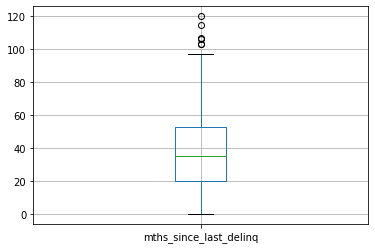

In [293]:
loans.boxplot(column='mths_since_last_delinq')

In [294]:
loans.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,...,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
count,37833.0000,37833.0000,37833.0000,37833.0000,37833.0000,37833.0000,37833.0000,37833.0000,37833.0000,37833.0000,...,37833.0000,37833.0000,37833.0000,37833.0000,37833.0000,37833.0000,37833.0000,37833.0000,37833.0000,37833.0000
mean,690017.2714,859792.5021,11328.4328,11050.3793,10618.6332,327.1402,69672.6446,13.3773,0.1458,0.8667,...,94.5497,12.1337,2730.4979,0.0000,1.0000,0.0000,0.0000,0.0000,0.0414,0.0000
std,202885.9503,254234.4735,7477.2734,7204.8821,7112.9011,209.0852,63644.6388,6.6561,0.4905,1.0664,...,690.3953,148.1131,4489.6693,0.0000,0.0000,0.0000,0.0000,0.0000,0.2002,0.0000
min,54734.0000,80364.0000,500.0000,500.0000,0.0000,16.0800,4000.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0100,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,521104.0000,673215.0000,5600.0000,5500.0000,5000.0000,168.7600,41900.0000,8.2700,0.0000,0.0000,...,0.0000,0.0000,224.7700,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,669340.0000,855613.0000,10000.0000,10000.0000,9200.0000,283.2000,60000.0000,13.4700,0.0000,1.0000,...,0.0000,0.0000,563.4300,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,839303.0000,1049074.0000,15000.0000,15000.0000,14603.0623,434.7500,83500.0000,18.6300,0.0000,1.0000,...,0.0000,0.0000,3401.3300,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
max,1077501.0000,1314167.0000,35000.0000,35000.0000,35000.0000,1305.1900,6000000.0000,29.9900,11.0000,8.0000,...,29623.3500,7002.1900,36115.2000,0.0000,1.0000,0.0000,0.0000,0.0000,2.0000,0.0000


Checking unique values in `member_id`, `id`.

In [295]:
len(loans)

37833

In [296]:
loans['member_id'].nunique()

37833

In [297]:
loans['id'].nunique()

37833

We can delete `member_id` and `id` as they will not help in the analysis

In [298]:
loans = loans.drop(['id'], axis=1)
loans = loans.drop(['member_id'], axis=1)

Find columns with less than 1 unique values

In [299]:
loans.columns[loans.nunique() <= 1]

Index(['pymnt_plan', 'initial_list_status', 'collections_12_mths_ex_med',
       'policy_code', 'application_type', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens'],
      dtype='object')

In [300]:
loans=loans.drop(['pymnt_plan', 'initial_list_status', 'collections_12_mths_ex_med','policy_code','application_type','acc_now_delinq','chargeoff_within_12_mths','delinq_amnt','tax_liens'], axis=1)


In [301]:
loans['loan_status'].value_counts()

Fully Paid     31533
Charged Off     5202
Current         1098
Name: loan_status, dtype: int64

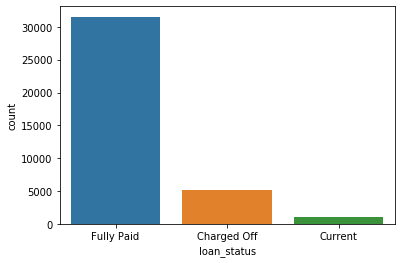

In [302]:
sns.countplot(x='loan_status',data=loans)

In [303]:
loans['loan_defaulted'] = loans['loan_status'].apply(lambda x: 'Y' if x =='Charged Off' else 'N')

In [304]:
loans['loan_defaulted'].value_counts()

N    32631
Y     5202
Name: loan_defaulted, dtype: int64

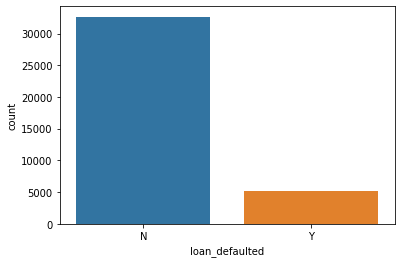

In [305]:
sns.countplot(x='loan_defaulted',data=loans)

In [306]:
print(5202/(32631+5202))

0.13749900880183966


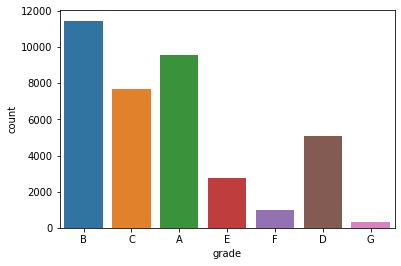

In [307]:
sns.countplot(x='grade',data=loans)

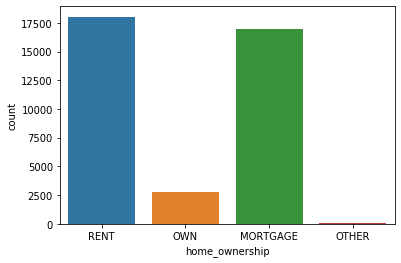

In [308]:
sns.countplot(x='home_ownership',data=loans)

Changing type of columns `collections_12_mths_ex_med`, `chargeoff_within_12_mths`, `pub_rec_bankruptcies` and `tax_liens` from float to int

In [309]:
loans_num = loans.select_dtypes(include=['int64','float64'])
loans_num.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,...,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,pub_rec_bankruptcies
count,37833.0000,37833.0000,37833.0000,37833.0000,37833.0000,37833.0000,37833.0000,37833.0000,12963.0000,37833.0000,...,37833.0000,37833.0000,37833.0000,37833.0000,37833.0000,37833.0000,37833.0000,37833.0000,37833.0000,37833.0000
mean,11328.4328,11050.3793,10618.6332,327.1402,69672.6446,13.3773,0.1458,0.8667,37.0687,9.3252,...,52.0756,12311.0705,11841.4386,9912.9670,2302.2193,1.3345,94.5497,12.1337,2730.4979,0.0414
std,7477.2734,7204.8821,7112.9011,209.0852,63644.6388,6.6561,0.4905,1.0664,21.3985,4.3754,...,379.1378,9083.4470,8947.0744,7089.4518,2633.8443,7.1791,690.3953,148.1131,4489.6693,0.2002
min,500.0000,500.0000,0.0000,16.0800,4000.0000,0.0000,0.0000,0.0000,0.0000,2.0000,...,0.0000,33.7300,0.0000,0.0000,6.2200,0.0000,0.0000,0.0000,0.0100,0.0000
25%,5600.0000,5500.0000,5000.0000,168.7600,41900.0000,8.2700,0.0000,0.0000,20.0000,6.0000,...,0.0000,5647.3192,5387.7500,4800.0000,677.1200,0.0000,0.0000,0.0000,224.7700,0.0000
50%,10000.0000,10000.0000,9200.0000,283.2000,60000.0000,13.4700,0.0000,1.0000,35.0000,9.0000,...,0.0000,10072.2142,9611.3900,8000.0100,1376.2400,0.0000,0.0000,0.0000,563.4300,0.0000
75%,15000.0000,15000.0000,14603.0623,434.7500,83500.0000,18.6300,0.0000,1.0000,53.0000,12.0000,...,0.0000,16717.6542,16108.8200,14000.0000,2889.1200,0.0000,0.0000,0.0000,3401.3300,0.0000
max,35000.0000,35000.0000,35000.0000,1305.1900,6000000.0000,29.9900,11.0000,8.0000,120.0000,44.0000,...,6307.3700,58563.6799,58563.6800,35000.0200,23563.6800,180.2000,29623.3500,7002.1900,36115.2000,2.0000


In [310]:
loans['pub_rec_bankruptcies'].value_counts()

0.0000    36272
1.0000     1554
2.0000        7
Name: pub_rec_bankruptcies, dtype: int64

We can see `pub_rec_bankruptcies` has 3 values, which can be considered as Ordinal categorical variable

In [311]:
loans['pub_rec_bankruptcies'] = loans['pub_rec_bankruptcies'].astype('category')